<a href="https://colab.research.google.com/github/sofiatil/NeuralNetworks-Python1/blob/main/evaluatingTransferLearningUsability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from keras.models import load_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the fashion-mnist dataset
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
# image normalization
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

In [ ]:
# label encoding to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
#define DNN and CNN model architectures

def build_dnn_model():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    return model

DNN_from_scratch = build_dnn_model()
DNN_from_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
DNN_from_scratch.summary()

In [ ]:
def build_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

CNN_from_scratch = build_cnn_model()
CNN_from_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN_from_scratch.summary()

In [ ]:

#define a method for calculating some classification metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt

dnn_models =[]

num_folds = 6
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

# define lists to hold the results
results = []

#save each one of the 6 models in a list, to get the best one after their evaluation
dnn_models=[]

# training the DNN model using stratified k fold validation
for fold_idx, (train_index, val_index) in enumerate(skf.split(train_images, np.argmax(train_labels, axis=1))):
    print(f"Fold {fold_idx+1}/{num_folds}")

    # separate the train and validation sets
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # load DNN model
    DNN_from_scratch = build_dnn_model()
    DNN_from_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # train the DNN model with train set and evaluate on validation set
    dnn_history = DNN_from_scratch.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val), verbose=1)


    #after trainign predict the val labels
    y_train_pred = DNN_from_scratch.predict(x_train)
    y_test_pred = DNN_from_scratch.predict(test_images)

    # evaluate the models on train and test sets
    dnn_train_acc, dnn_train_precision, dnn_train_recall, dnn_train_f1 = calculate_metrics(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
    dnn_test_acc, dnn_test_precision, dnn_test_recall, dnn_test_f1 = calculate_metrics(np.argmax(test_labels, axis=1), np.argmax(y_test_pred, axis=1))

    #add model to the list
    dnn_models.append(['DNN-'+str(fold_idx+1), DNN_from_scratch,dnn_test_f1])

    # append the results
    results.append(['DNN-FROM-SCRATCH', 'Train', fold_idx+1, dnn_train_acc, dnn_train_precision, dnn_train_recall, dnn_train_f1])
    results.append(['DNN-FROM-SCRATCH', 'Test', fold_idx+1, dnn_test_acc, dnn_test_precision, dnn_test_recall, dnn_test_f1])

#plot accuracy and loss for train-validation set (only for the last fold)
plt.plot(dnn_history.history['accuracy'])
plt.plot(dnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_models =[]

# training the CNN model and evaluating
for fold_idx, (train_index, val_index) in enumerate(skf.split(train_images, np.argmax(train_labels, axis=1))):
    print(f"Fold {fold_idx+1}/{num_folds}")

    # separate the train and validation sets
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # load CNN model
    CNN_from_scratch = build_cnn_model()
    CNN_from_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # train the CNN model with validation set
    cnn_history = CNN_from_scratch.fit(x_train, y_train, epochs=150, batch_size=64, validation_data=(x_val, y_val), verbose=1)

    #after trainign predict the val labels
    y_train_pred = CNN_from_scratch.predict(x_train)
    y_test_pred = CNN_from_scratch.predict(test_images)

    # evaluate the CNN model on train and test sets
    cnn_train_acc, cnn_train_precision, cnn_train_recall, cnn_train_f1 = calculate_metrics(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
    cnn_test_acc, cnn_test_precision, cnn_test_recall, cnn_test_f1 = calculate_metrics(np.argmax(test_labels, axis=1), np.argmax(y_test_pred, axis=1))

    # append the current cnn model and its f1 score to the list
    cnn_models.append(['CNN-'+str(fold_idx+1), CNN_from_scratch, cnn_test_f1])

    # append the results
    results.append(['CNN-FROM-SCRATCH', 'Train', fold_idx+1, cnn_train_acc, cnn_train_precision, cnn_train_recall, cnn_train_f1])
    results.append(['CNN-FROM-SCRATCH', 'Test', fold_idx+1, cnn_test_acc, cnn_test_precision, cnn_test_recall, cnn_test_f1])

#plot accuracy and loss for train-validation set (only for the last fold)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



# Create DataFrame
columns = ['Technique', 'Set', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df = pd.DataFrame(results, columns=columns)

Fold 1/6
Epoch 1/150
143/782 [====>.........................] - ETA: 36s - loss: 1.0481 - accuracy: 0.6175

In [ ]:
# plot f1-score and precision for DNN_from_scratch CNN_from_scratch
DNN_x_axis = ['DNN-1', 'DNN-2', 'DNN-3', 'DNN-4', 'DNN-5', 'DNN-6']
DNN_prec_values = []
DNN_f1_values=[]

for ind in results_df.index:
  if results_df['Technique'][ind]=='DNN-FROM-SCRATCH' and results_df['Set'][ind]=='Test':
      DNN_prec_values.append(results_df['Precision'][ind])
      DNN_f1_values.append(results_df['F1 Score'][ind])


CNN_x_axis = ['CNN-1', 'CNN-2', 'CNN-3', 'CNN-4', 'CNN-5', 'CNN-6']
CNN_prec_values = []
CNN_f1_values=[]

for ind in results_df.index:
  if results_df['Technique'][ind]=='CNN-FROM-SCRATCH' and results_df['Set'][ind]=='Test':
      # print(results_df['F1 Score'][ind])
      CNN_prec_values.append(results_df['Precision'][ind])
      CNN_f1_values.append(results_df['F1 Score'][ind])


# Plot  F1-scores and precision for DNN models and CNN models
# Compare the models of each architecture considering these two metrics


plt.title("DNN_transfer precision in Test Set")
plt.bar(DNN_x_axis, DNN_prec_values)
plt.show()

In [ ]:
# Find the best DNN_from scratch and the best CNN_scratch

dnn_f1_df = pd.DataFrame(dnn_models, columns = ['Model Name', 'Model Object', 'F1-Score'])
best_ind = dnn_f1_df['F1-Score'].idxmax()
best_dnn = dnn_f1_df.loc[best_ind, 'Model Object']


cnn_f1_df = pd.DataFrame(cnn_models, columns = ['Model Name', 'Model Object', 'F1-Score'])
best_ind = cnn_f1_df['F1-Score'].idxmax()
best_dnn = cnn_f1_df.loc[best_ind, 'Model Object']


DNN **Transfer** - CNN **Transfer**



Fold 1/6
Train only the last layer
Epoch 1/40
782/782 [==============================] - 6s 7ms/step - loss: 2.1265 - accuracy: 0.3987 - val_loss: 1.1305 - val_accuracy: 0.6321
Epoch 2/40
782/782 [==============================] - 5s 6ms/step - loss: 1.2584 - accuracy: 0.5384 - val_loss: 1.0583 - val_accuracy: 0.6505
Epoch 3/40
782/782 [==============================] - 4s 5ms/step - loss: 1.2230 - accuracy: 0.5450 - val_loss: 1.0443 - val_accuracy: 0.6332
Epoch 4/40
782/782 [==============================] - 5s 7ms/step - loss: 1.1960 - accuracy: 0.5569 - val_loss: 1.0241 - val_accuracy: 0.6429
Epoch 5/40
782/782 [==============================] - 6s 8ms/step - loss: 1.1847 - accuracy: 0.5574 - val_loss: 1.0181 - val_accuracy: 0.6497
Epoch 6/40
782/782 [==============================] - 4s 5ms/step - loss: 1.1808 - accuracy: 0.5583 - val_loss: 1.0108 - val_accuracy: 0.6578
Epoch 7/40
782/782 [==============================] - 5s 6ms/step - loss: 1.1782 - accuracy: 0.5604 - val_loss: 0

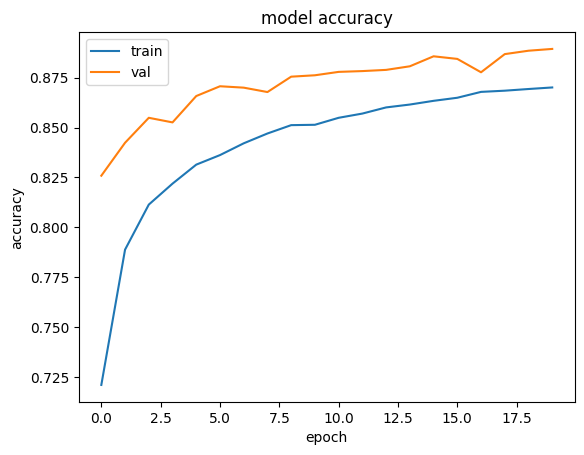

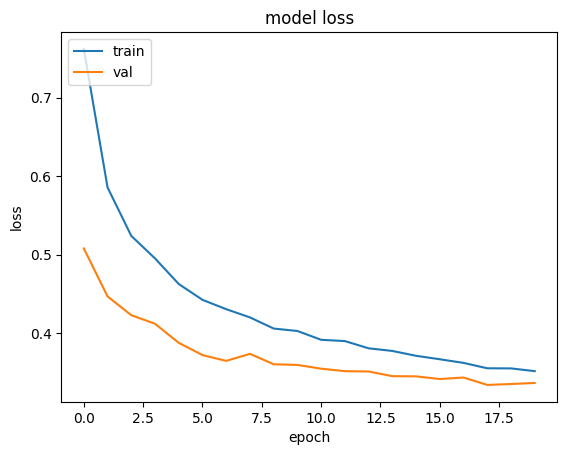

In [ ]:


# define a list to store the DNN_transfer models and their F1-scores in the test set
dnn_trans_models=[]
results=[]

num_folds = 6
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)


for fold_idx, (train_index, val_index) in enumerate(skf.split(train_images, np.argmax(train_labels, axis=1))):
    print(f"Fold {fold_idx+1}/{num_folds}")

    # Separate train and validation sets
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]


    # Compile the model
    DNN_transfer = load_model("/content/drive/MyDrive/Neural Networks - assignment 1/bestDNN.h5")

    # Freeze layers except the last one
    for layer in DNN_transfer.layers[:-1]:
       layer.trainable = False

    # train only the last layer
    print('Train only the last layer')
    DNN_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    DNN_transfer.fit(x_train, y_train, epochs=40, batch_size=64, validation_data=(x_val, y_val), verbose=1)

    # unfreeze
    for layer in DNN_transfer.layers:
        layer.trainable = True

    print("Fine-Tunning Train End-To-End\n")

    # End-to-end training for 20 epochs
    DNN_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    dnn_history_transfer = DNN_transfer.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val), verbose=1)
    y_train_pred = DNN_transfer.predict(x_train)
    y_test_pred = DNN_transfer.predict(test_images)

    # Evaluate the model
    dnn_train_acc2, dnn_train_precision2, dnn_train_recall2, dnn_train_f12 = calculate_metrics(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
    dnn_test_acc2, dnn_test_precision2, dnn_test_recall2, dnn_test_f12 = calculate_metrics(np.argmax(test_labels, axis=1), np.argmax(DNN_transfer.predict(test_images), axis=1))

    # append the current cnn model and its f1 score to the list
    dnn_trans_models.append(['DNN-'+str(fold_idx+1), DNN_transfer, dnn_test_f12])

    # Append the results
    results.append(['DNN_transfer', 'Train', fold_idx+1, dnn_train_acc2, dnn_train_precision2, dnn_train_recall2, dnn_train_f12])
    results.append(['DNN_transfer', 'Test', fold_idx+1, dnn_test_acc2, dnn_test_precision2, dnn_test_recall2, dnn_test_f12])



#plot accuracy and loss for train-validation set (only for the last fold) (DNN)
plt.plot(dnn_history_transfer.history['accuracy'])
plt.plot(dnn_history_transfer.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(dnn_history_transfer.history['loss'])
plt.plot(dnn_history_transfer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:

# create a list to save CNN_transfer models with their f1-scores on test set
cnn_trans_models = []


for fold_idx, (train_index, val_index) in enumerate(skf.split(train_images, np.argmax(train_labels, axis=1))):
    print(f"Fold {fold_idx+1}/{num_folds}")

    # Separate train and validation sets
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # load the pre-trained CNN
    CNN_transfer = load_model("/content/drive/MyDrive/Neural Networks - assignment 1/bestCNN.h5")

    # Freeze layers except the last one
    for layer in CNN_transfer.layers[:-1]:
      layer.trainable = False

    CNN_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # train only the last layer
    cnn_history_transfer = CNN_transfer.fit(x_train, y_train, epochs=40, batch_size=64, validation_data=(x_val, y_val), verbose=1)

    # unfreeze the convolutional layers and train end-to-end
    for layer in CNN_transfer.layers:
      layer.trainable = True


    # Continue training for 20 epochs
    CNN_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_history_transfer = CNN_transfer.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val), verbose=1)

    y_train_pred = CNN_transfer.predict(x_train)
    y_test_pred = CNN_transfer.predict(test_images)

    # Evaluate the model
    cnn_train_acc2, cnn_train_precision2, cnn_train_recall2, cnn_train_f12 = calculate_metrics(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
    cnn_test_acc2, cnn_test_precision2, cnn_test_recall2, cnn_test_f12 = calculate_metrics(np.argmax(test_labels, axis=1), np.argmax(CNN_transfer.predict(test_images), axis=1))

    cnn_trans_models.append(['CNN-'+str(fold_idx+1), CNN_transfer, cnn_test_f12])

    # Append the results
    results.append(['CNN_transfer', 'Train', fold_idx+1, cnn_train_acc2, cnn_train_precision2, cnn_train_recall2, cnn_train_f12])
    results.append(['CNN_transfer', 'Test', fold_idx+1, cnn_test_acc2, cnn_test_precision2, cnn_test_recall2, cnn_test_f12])


#plot accuracy and loss for train-validation set (only for the last fold) (CNN)
plt.plot(cnn_history_transfer.history['accuracy'])
plt.plot(cnn_history_transfer.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(cnn_history_transfer.history['loss'])
plt.plot(cnn_history_transfer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




In [ ]:
columns = ['Technique', 'Set', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df = pd.DataFrame(results, columns=columns)

# Save DataFrame as CSV
# results_df.to_csv('erotima2.csv', index=False)
results_df.to_csv('transfer.csv', index=False)

In [ ]:
# Plot  F1-scores and precision for DNN models and CNN models
# Compare the models of each architecture considering these two metrics

DNN_trans_x_axis = ['DNN-1', 'DNN-2', 'DNN-3', 'DNN-4', 'DNN-5', 'DNN-6']
DNN_trans_prec_values = []
DNN_trans_f1_values=[]

for ind in results_df.index:
  if results_df['Technique'][ind]=='DNN_transfer' and results_df['Set'][ind]=='Test':
      DNN_trans_prec_values.append(results_df['Precision'][ind])
      DNN_trans_f1_values.append(results_df['F1 Score'][ind])


CNN_trans_x_axis = ['CNN-1', 'CNN-2', 'CNN-3', 'CNN-4', 'CNN-5', 'CNN-6']
CNN_trans_prec_values = []
CNN_trans_f1_values=[]

for ind in results_df.index:
  if results_df['Technique'][ind]=='CNN_transfer' and results_df['Set'][ind]=='Test':
      # print(results_df['F1 Score'][ind])
      CNN_trans_prec_values.append(results_df['Precision'][ind])
      CNN_trans_f1_values.append(results_df['F1 Score'][ind])


# Plot  F1-scores and precision for DNN models and CNN models
# Compare the models of each architecture considering these two metrics


plt.title("DNN_transfer precision in Test Set")
plt.bar(DNN_trans_x_axis, DNN_trans_prec_values)
plt.show()

plt.title("DNN_transfer F1 Score in Test Set")
plt.bar(DNN_trans_x_axis, DNN_trans_f1_values)
plt.show()


plt.title("CNN_transfer precision in Test Set")
plt.bar(CNN_trans_x_axis, DNN_trans_prec_values)
plt.show()

plt.title("CNN_transfer F1 Score in Test Set")
plt.bar(CNN_trans_x_axis, DNN_trans_f1_values)
plt.show()

In [ ]:
# Find the best DNN_transfer
dnn_trans_f1_df = pd.DataFrame(dnn_trans_models, columns=['Model Name', 'Model Object', 'F1-Score'])

best_ind = dnn_trans_f1_df['F1-Score'].idxmax()
best_dnn = dnn_trans_f1_df.loc[best_ind, 'Model Object']


# Find the best CNN_transfer
cnn_trans_f1_df = pd.DataFrame(cnn_trans_models, columns=['Model Name', 'Model Object', 'F1-Score'])

best_ind = cnn_trans_f1_df['F1-Score'].idxmax()
best_dnn = cnn_trans_f1_df.loc[best_ind, 'Model Object']


In [ ]:
DNN_x_axis = ['DNN-1', 'DNN-2', 'DNN-3', 'DNN-4', 'DNN-5', 'DNN-6']
DNN_prec_values = []
DNN_trans_f1_values=[]

for ind in results_df.index:
  if results_df['Technique'][ind]=='DNN_transfer' and results_df['Set'][ind]=='Test':
      DNN_trans_prec_values.append(results_df['Precision'][ind])
      DNN_trans_f1_values.append(results_df['F1 Score'][ind])


CNN_trans_x_axis = ['CNN-1', 'CNN-2', 'CNN-3', 'CNN-4', 'CNN-5', 'CNN-6']
CNN_trans_prec_values = []
CNN_trans_f1_values=[]

for ind in results_df.index:
  if results_df['Technique'][ind]=='CNN_transfer' and results_df['Set'][ind]=='Test':
      # print(results_df['F1 Score'][ind])
      CNN_trans_prec_values.append(results_df['Precision'][ind])
      CNN_trans_f1_values.append(results_df['F1 Score'][ind])


# Plot  F1-scores and precision for DNN models and CNN models
# Compare the models of each architecture considering these two metrics


plt.title("DNN_transfer precision in Test Set")
plt.bar(DNN_trans_x_axis, DNN_trans_prec_values)
plt.show()

plt.title("DNN_transfer F1 Score in Test Set")
plt.bar(DNN_trans_x_axis, DNN_trans_f1_values)
plt.show()


plt.title("CNN_transfer precision in Test Set")
plt.bar(CNN_trans_x_axis, DNN_trans_prec_values)
plt.show()

plt.title("CNN_transfer F1 Score in Test Set")
plt.bar(CNN_trans_x_axis, DNN_trans_f1_values)
plt.show()